# Librerías

In [1]:
#!pip install pysqlite3

In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from google.colab import files
import os
import sys

#Librerias estadísticas y de pruebas
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from plotly.subplots import make_subplots

import datetime

# Conectar con google drive


In [37]:
drive.flush_and_unmount()

In [38]:
#drive.flush_and_unmount()  #Linea en caso de tener que desconectar el drive por algún tipo de falla
drive.mount('/content/drive') #Linea para conectar al drive

Mounted at /content/drive


In [39]:
path="/content/drive/MyDrive/analitica 3/sistemas_recomendacion" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [40]:
import funciones as fn

# Base de datos

In [9]:
conn = sql.connect('/content/drive/MyDrive/analitica 3/sistemas_recomendacion/data/db_movies3')
cur = conn.cursor()

In [10]:
# Creación de cursor para  ejecutar consultas en la base de datos
# Visualizar las tablas contenidas en la base de datos
cur.execute("SELECT name FROM sqlite_master where type='table'")
cur.fetchall()

[('movies_final',), ('ratings_final',), ('df_final',)]

## Carga de tabla en variable y visualización

In [11]:
cur.execute("SELECT * from df_final")
cur.fetchall()

[(1,
  1,
  4.0,
  2000,
  7,
  30,
  'Toy Story (1995)',
  1995.0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0),
 (3,
  1,
  4.0,
  2000,
  7,
  30,
  'Grumpier Old Men (1995)',
  1995.0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0),
 (6,
  1,
  4.0,
  2000,
  7,
  30,
  'Heat (1995)',
  1995.0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0),
 (47,
  1,
  5.0,
  2000,
  7,
  30,
  'Seven (a.k.a. Se7en) (1995)',
  1995.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0),
 (50,
  1,
  5.0,
  2000,
  7,
  30,
  'Usual Suspects, The (1995)',
  1995.0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0),
 (70,
  1,
  3.0,
  2000,
  7,
  30,
  'From Dusk Till Dawn (1996)',
  1996.0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
 

In [12]:
print("\nPrimeras 5 filas:")
df_final = pd.read_sql("SELECT * from df_final",conn)
df_final.head()


Primeras 5 filas:


,movie_id,user_id,rating,year_ratings,month,day,title,year_movies,Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000,7,30,Toy Story (1995),1995.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,4.0,2000,7,30,Grumpier Old Men (1995),1995.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6,1,4.0,2000,7,30,Heat (1995),1995.0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1,5.0,2000,7,30,Seven (a.k.a. Se7en) (1995),1995.0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,50,1,5.0,2000,7,30,"Usual Suspects, The (1995)",1995.0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Limpieza

## Cambio de tipo de variable

In [13]:
print(df_final.dtypes)

movie_id          int64
user_id           int64
rating          float64
year_ratings      int64
month             int64
day               int64
title            object
year_movies     float64
Action            int64
Adventure         int64
Animation         int64
Children          int64
Comedy            int64
Crime             int64
Documentary       int64
Drama             int64
Fantasy           int64
Film-Noir         int64
Horror            int64
IMAX              int64
Musical           int64
Mystery           int64
Romance           int64
Sci-Fi            int64
Thriller          int64
War               int64
Western           int64
dtype: object


Por medio del análisis de cada variable de identifica que "user_id", "movie_id" son variables categóricas y no numéricas, esto debido a que su función es de darle una identificación a cada usuario y película.

In [33]:
df_final['user_id'] = df_final['user_id'].astype('object')
df_final['movie_id'] = df_final['movie_id'].astype('object')
df_final['day'] = df_final['day'].astype('object')
df_final['month'] = df_final['month'].astype('object')
df_final['year_movies'] = df_final['year_movies'].astype('object')
df_final['year_ratings'] = df_final['year_ratings'].astype('object')
genero_cols = [
    'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Action'
]
df_final[genero_cols] = df_final[genero_cols].astype('object')


df_final.dtypes

,0
movie_id,object
user_id,object
rating,float64
year_ratings,object
month,object
day,object
title,object
year_movies,object
Action,object
Adventure,object


## Datos atípicos

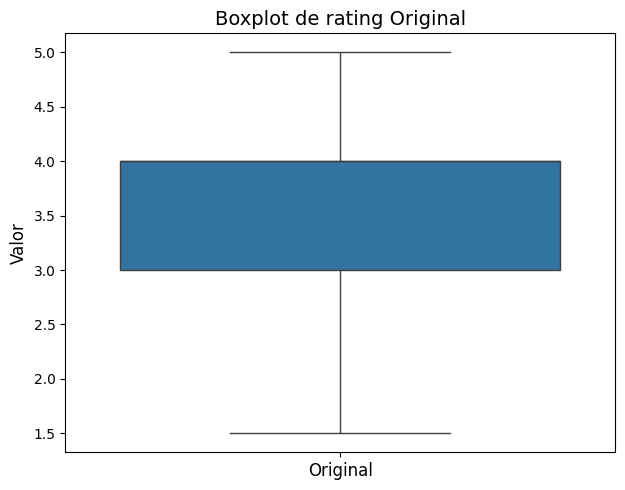

In [34]:
def visual_outliers(df):
    # Seleccionar columnas numéricas y excluir las de géneros
    numeric_cols = df.select_dtypes(include='number').columns

    df_comparison = pd.DataFrame()
    for col in numeric_cols:
        df_comparison[f'{col}_original'] = df[col]

    num_vars = len(numeric_cols)
    n_cols = 2
    n_rows = (num_vars + n_cols - 1) // n_cols

    # Boxplots
    plt.figure(figsize=(12, 5 * n_rows))
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df_comparison[[f'{col}_original']])
        plt.title(f'Boxplot de {col} Original', fontsize=14)
        plt.xticks([0], ['Original'], fontsize=12)
        plt.xlabel('')
        plt.ylabel('Valor', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Histogramas con KDE
    fig_hist = make_subplots(n_rows, n_cols, subplot_titles=[f'Histograma {column}' for column in numeric_cols], shared_yaxes=True)
    for i, column in enumerate(numeric_cols):
        hist = go.Histogram(x=df[column], name=f'Histograma {column}', nbinsx=30, opacity=0.75,
                            marker=dict(color='blue', line=dict(color='black', width=1)))
        fig_hist.add_trace(hist, row=(i // n_cols) + 1, col=(i % n_cols) + 1)

        kde = gaussian_kde(df[column], bw_method='scott')
        x = np.linspace(df[column].min(), df[column].max(), 1000)
        p = kde(x)
        hist_values, bin_edges = np.histogram(df[column], bins=30)
        kde_scaled = p * np.max(hist_values) / np.max(p)

        fig_hist.add_trace(go.Scatter(x=x, y=kde_scaled, mode='lines', name=f'KDE {column}',
                                      line=dict(color='red')), row=(i // n_cols) + 1, col=(i % n_cols) + 1)

    fig_hist.update_layout(height=300 * n_rows, width=800, title_text="Histogramas variables numéricas con KDE")
    fig_hist.show()
visual_outliers(df_final)

In [22]:
def contar_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outliers_count = {
        col: ((df[col] < df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))) |
              (df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))).sum()
        for col in numeric_cols
    }
    return pd.DataFrame(list(outliers_count.items()), columns=['Variable', 'Cantidad de Atípicos'])
contar_outliers_iqr(df_final)
outliers_df

,Variable,Cantidad de Atípicos
0,rating,2811
1,year_movies,5604


In [43]:
# prompt: Imputación de atípicos con la media

import numpy as np
# Imputación de atípicos con la media

def impute_outliers_with_mean(df, column):
    """
    Imputa los valores atípicos de una columna con la media de la columna.

    Args:
        df: DataFrame de pandas.
        column: Nombre de la columna a imputar.
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if column not in numeric_cols:
        print(f"La columna '{column}' no es numérica.")
        return df

    col_data = df[column].dropna()

    # Calcular IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar y reemplazar los valores atípicos con la media
    mean_value = col_data.mean()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = mean_value
    return df

df_final = impute_outliers_with_mean(df_final, 'rating')
df_final.head()

,movie_id,user_id,rating,year_ratings,month,day,title,year_movies,Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000,7,30,Toy Story (1995),1995,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,4.0,2000,7,30,Grumpier Old Men (1995),1995,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6,1,4.0,2000,7,30,Heat (1995),1995,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1,5.0,2000,7,30,Seven (a.k.a. Se7en) (1995),1995,0,0,...,0,0,0,0,1,0,0,1,0,0
4,50,1,5.0,2000,7,30,"Usual Suspects, The (1995)",1995,0,0,...,0,0,0,0,1,0,0,1,0,0


In [44]:
#Verifiquemos que si esten impuntando los atipicos de la variable rating
outliers_df = contar_outliers_iqr(df_final)
outliers_df

,Variable,Cantidad de Atípicos
0,rating,0


In [45]:
#Verificar si algun valor de rating esta por debajo de 0.5 o por encima de 5.0 y corregirlo
invalid_ratings = df_final[(df_final['rating'] < 0.5) | (df_final['rating'] > 5.0)].shape[0]
print(f"Ratings inválidos: {invalid_ratings}")

Ratings inválidos: 0


In [46]:
# Ver si hay peliculas con fechas futuras y de antes del año 1940
pelis_futuras = df_final[df_final['year_movies'] > datetime.datetime.now().year].shape[0]
pelis_antiguas = df_final[df_final['year_movies'] < 1940].shape[0]

print(f"Películas con año en el futuro: {pelis_futuras}")
print(f"Películas anteriores al año 1940: {pelis_antiguas}")

Películas con año en el futuro: 0
Películas anteriores al año 1940: 0


En este caso no hay fechas futuras ni fechas muy antiguas debido a la aplicacion de un filtro previo en el preprocesamiento de sql

## Pruebas de normalidad de algunas variables relevantes

In [27]:
#Prueba de normalidad estadistica

def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
variables = numeric_cols
prueba_normalidad(df_final, variables)

Prueba de Normalidad de Shapiro-Wilk para rating:
Estadístico: 0.9403602706857414, Valor-p: 7.945735954339573e-94
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_movies:
Estadístico: 0.8951520077503695, Valor-p: 1.9340149731495513e-108
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 79195.



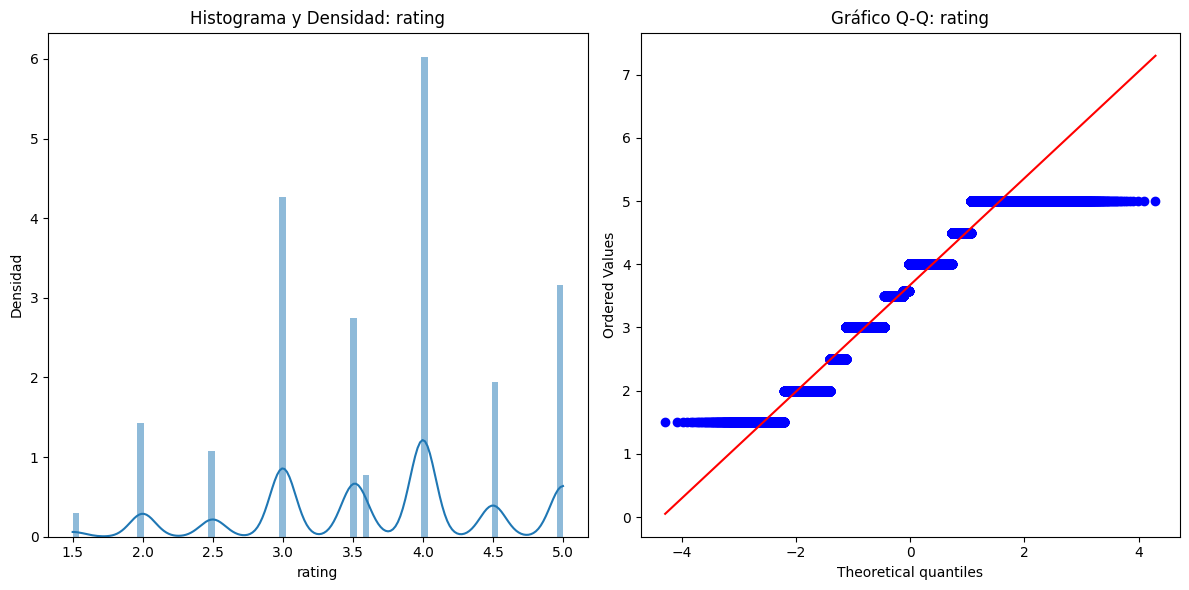

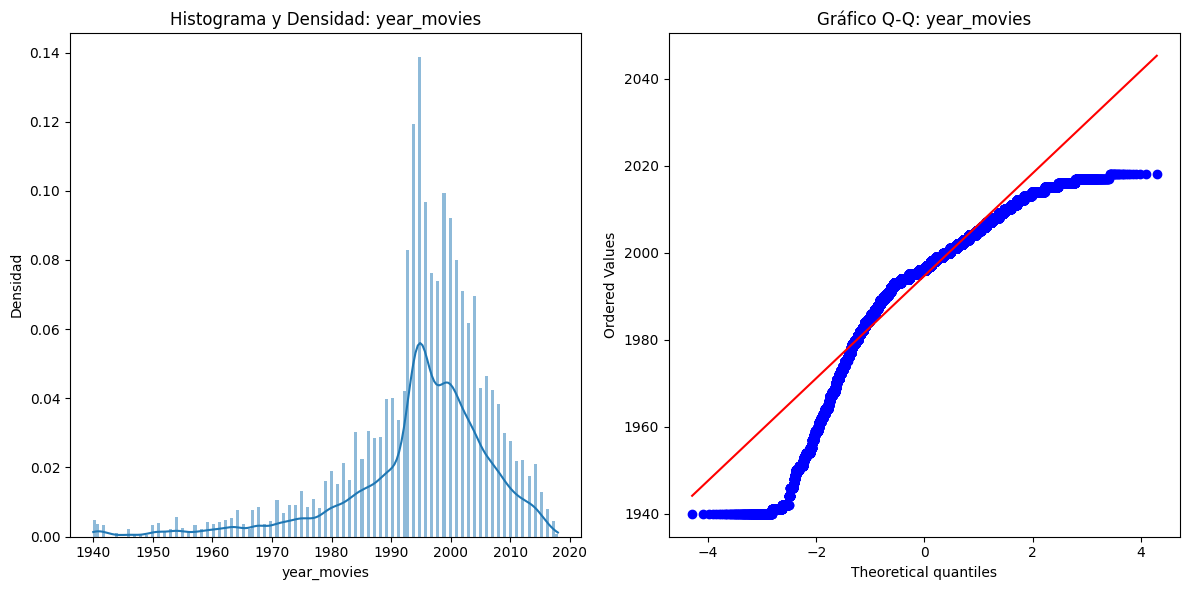

In [28]:
#Prueba de normalidad grafica

def evaluar_normalidad(df, variables):

    for var in variables:
        plt.figure(figsize=(12, 6))

        # Histograma con línea de densidad
        plt.subplot(1, 2, 1)
        sns.histplot(df[var], kde=True, stat='density', linewidth=0)
        plt.title(f'Histograma y Densidad: {var}')
        plt.xlabel(var)
        plt.ylabel('Densidad')

        # Gráfico Q-Q
        plt.subplot(1, 2, 2)
        stats.probplot(df[var].dropna(), dist="norm", plot=plt)
        plt.title(f'Gráfico Q-Q: {var}')

        plt.tight_layout()
        plt.show()

evaluar_normalidad(df_final, variables)

### Transformación de los datos en busca de distribución normal

In [31]:
#Copia de dataframe para modificar
dfc_transformado = df_final.copy()

# Aplicar las transformaciones logarítmicas sobre la copia
dfc_transformado['rating'] = np.log1p(dfc_transformado['rating'])
dfc_transformado['year_movies'] = np.log1p(dfc_transformado['year_movies'])

dfc_transformado[['rating', 'year_movies']] = StandardScaler().fit_transform(dfc_transformado[['rating', 'year_movies']])  # Estandarización

In [32]:
numeric = dfc_transformado.select_dtypes(include=[np.number]).columns
def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
prueba_normalidad(dfc_transformado, numeric)

Prueba de Normalidad de Shapiro-Wilk para rating:
Estadístico: 0.9158923915266995, Valor-p: 1.3297832129296365e-102
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_movies:
Estadístico: 0.8919984226531471, Valor-p: 3.083999452483823e-109
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 79195.



In [ ]:
#Guardar conjunto de datos limpio
df_final.to_csv('/content/drive/MyDrive/analitica 3/sistemas_recomendacion/data/movies_limpio.csv', index=False)